<a href="https://colab.research.google.com/github/ayushabhinav/SentimentalAnalysis/blob/main/Sentimental_Analysis_CMU_MOSI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import os
import requests
import warnings
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 31.2 MB/s 


In [3]:
import numpy as np
import pandas as pd

from sklearn import metrics

import tensorflow_addons as tfa

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, LSTM, Dense, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [4]:
warnings.filterwarnings('ignore')
tf.random.set_seed(24)

In [5]:
# Download CMU_MOSI Data file
data_file = 'mosi_data_50.pkl'

if not os.path.exists(data_file):
  res = requests.get('http://immortal.multicomp.cs.cmu.edu/raw_datasets/processed_data/cmu-mosi/seq_length_50/mosi_data.pkl')
  with open(data_file , 'wb') as outfile:
    outfile.write(res.content)

# !wget http://immortal.multicomp.cs.cmu.edu/raw_datasets/processed_data/cmu-mosi/seq_length_50/mosi_data.pkl

In [6]:
# !mv mosi_data.pkl mosi_data_50.pkl
!ls -lrt

total 150440
drwxr-xr-x 1 root root      4096 Aug 15 13:44 sample_data
-rw-r--r-- 1 root root 154041300 Aug 25 10:19 mosi_data_50.pkl


In [7]:
# Load data from pickled file
data = None
with open(data_file, 'rb') as infile:
  data = pkl.load(infile)

In [8]:
data.keys()

dict_keys(['valid', 'test', 'train'])

In [9]:
# Seperate data in train, test and validation sets
data_train = data['train']
data_test = data['test']
data_valid = data['valid']

In [114]:
data_test_label_actual = np.squeeze(data_test['labels'] > 0.5)

In [10]:
data_train.keys()

dict_keys(['vision', 'labels', 'text', 'audio', 'id'])

In [11]:
# labels are here for the regesssion purpose
data_train['labels']

array([[[-0.5]],

       [[-1.2]],

       [[ 1.8]],

       ...,

       [[ 0.6]],

       [[-0.4]],

       [[ 2. ]]])

In [12]:
# pd.DataFrame({'id':data_valid['id']})
valid_data_df = pd.DataFrame({
                    'f_name': data_valid['id'][:,0],
                    's_time': data_valid['id'][:,1],
                    'e_time': data_valid['id'][:,2],
                    'true_labels' : np.squeeze(data_valid['labels'][:,0] >= 0)
                })
valid_data_df

,f_name,s_time,e_time,true_labels
0,b'WKA5OygbEKI_20',b'131.7929705',b'133.6886621',True
1,b'WKA5OygbEKI_21',b'133.6886621',b'138.976644',True
2,b'WKA5OygbEKI_22',b'170.544898',b'172.729932',True
3,b'WKA5OygbEKI_1',b'4.432426304',b'8.852380952',True
4,b'WKA5OygbEKI_3',b'45.95804989',b'49.69954649',True
...,...,...,...,...
224,b'c5xsKMxpXnc_4',b'133.2097506',b'135.8836735',True
225,b'c5xsKMxpXnc_7',b'149.3829932',b'152.4360544',False
226,b'c5xsKMxpXnc_6',b'146.7290249',b'149.3829932',False
227,b'c5xsKMxpXnc_9',b'156.6764172',b'159.0609977',False


### Analysis On the textual data as regression

In [13]:
# import tensorflow.keras as keras
# from tensorflow.keras.layers import Input, LSTM, Dense, Masking
# from tensorflow.keras.models import Model
# from tensorflow.keras.utils import plot_model

In [14]:
# # function to build the model with different configuration
# def get_model(n_unit=64, n_layer=1, mask_value=0.0, seq_len=50, latent_dim=300,
#               model_name='model_name'):
#   input_shape = (seq_len, latent_dim)
#   mask_value = np.zeros(shape=(latent_dim,), dtype=np.float32)

#   input = Input(shape=input_shape, name='input_layer')
#   mask_lyr = Masking(mask_value=mask_value, name='masking_layer')

#   layers = []
#   for id in range(1, n_layer+1):
#     if id != n_layer:
#       layers.append(
#           LSTM(n_unit, return_sequences=True, name=f'lstm_layer_{id}') 
#       )
#     else:
#       layers.append(
#        LSTM(n_unit, return_sequences=False, name=f'lstm_layer_{id}')   
#       )
#   layers.append(
#       Dense(1, activation='relu', name='dense_layer')
#   )

#   x = mask_lyr(input)
#   for layer in layers:
#     x = layer(x)

#   model = Model(inputs=input, outputs=x, name=model_name)
#   return model


In [15]:
# # preparing the data for training
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# buffer_size = 64
# batch_size = 64

# train_ds = tf.data.Dataset.from_tensor_slices(
#                 (
#                     data_train['text'], 
#                     data_train['labels']
#                 )
#             ).map(lambda x,y: (x, y+3)) \
#             .shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

# valid_ds = tf.data.Dataset.from_tensor_slices(
#                 (
#                     data_valid['text'],
#                     data_valid['labels']
#                 )
#             ).map(lambda x,y: (x, y+3)) \
#             .shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

In [16]:
# for data in train_ds.take(1):
#   print(data)

In [17]:
# # compile the model
# def compile_model(model):

#   optimizer = tf.keras.optimizers.Adam()
#   loss = tf.keras.losses.MeanSquaredError()
#   metrics = tf.keras.metrics.RootMeanSquaredError()


#   model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
#   print(f'Model-{model.name} is compiled successfully')

In [18]:
# # train and plot losses
# def train_plot_result(model, train_ds=train_ds, val_ds=valid_ds, epochs=500, verbose=1, **kwargs):
#     file_path = os.path.join(os.getcwd(), f'{model.name}_checkpoint')
#     if not os.path.exists(file_path):
#       os.makedirs(file_path)

#     early_stopping   = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#     model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=file_path, save_best_only=True)
#     callbacks = [early_stopping, model_checkpoint]

#     history = model.fit(train_ds, epochs=epochs, validation_data=valid_ds, callbacks=callbacks,verbose=verbose, **kwargs)
    
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']

#     plt.plot(loss, label='train_loss')
#     plt.plot(val_loss, label='val_loss')
#     plt.legend()
#     plt.title(f'{model.name} losses')
#     plt.show()
#     return history

In [19]:
# # plot correctness of pred wrt actual value
# def check_correctness(model, data_X, data_y):

#   y_pred = np.squeeze(np.ceil(model(data_X)))
#   y_true = np.squeeze( np.ceil(data_y) )

#   true_match = sum(y_pred == y_true)
#   print(f'Accuracy: {round(true_match * 100 /len(y_pred), 2)}%')

#   plt.title('Pred Vs Actual Classes Matching')
#   sns.countplot(y_pred == y_true )
#   plt.show()

#   plt.title('Pred Class Count')
#   sns.countplot(y_pred)
#   plt.show()

#   plt.title('Actual Class Count ')
#   sns.countplot(y_true)
#   plt.show()

##### Model - 1LSTM64

In [20]:
# model1 = get_model(model_name='Basic_Model-1LSTM64')
# model1.summary()

In [21]:
# compile_model(model1)
# train_plot_result(model1)
# # model1.fit(train_ds, validation_data=valid_ds, epochs=50)

In [22]:
# check_correctness(model1, data_train['text'], data_train['labels'])

##### Model 2LSTM64

In [23]:
# model2 = get_model(model_name='Basic_Model_2LSTM64', n_unit=64, n_layer=2)
# compile_model(model2)

In [24]:
# model2.summary()

In [25]:
# train_plot_result(model2)

In [26]:
# check_correctness(model2, data_train['text'], data_train['labels'])

##### model 1lSTM128

In [27]:
# model3 = get_model(model_name='Basic_Model_1LSTM128', n_unit=128)
# compile_model(model3)

In [28]:
# train_plot_result(model3)

In [29]:
# check_correctness(model3, data_train['text'], data_train['labels'])

###### Model 2LSTM128

In [30]:
# model4 = get_model(model_name='Basic_Model_2LSTM128', n_unit=128, n_layer=2)
# compile_model(model4)

In [31]:
# train_plot_result(model4)

In [32]:
# check_correctness(model4, data_train['text'], data_train['labels'])

##### model 1LSTM256

In [33]:
# model5 = get_model(model_name='Basic_Model_1LSTM256', n_unit=256)
# compile_model(model5)

In [34]:
# train_plot_result(model5)

In [35]:
# check_correctness(model5, data_train['text'], data_train['labels'])

##### model 2LSTM256

In [36]:
# model6 = get_model(model_name='Basic_Model_2LSTM256', n_unit=256, n_layer=2)
# compile_model(model6)

In [37]:
# train_plot_result(model6)

In [38]:
# check_correctness(model6, data_train['text'], data_train['labels'])

### Adding Attention Layer

#### Method 1

In [39]:

# from tensorflow.keras import initializers, regularizers, constraints

# def dot_product(x, kernel):
#     """
#     Wrapper for dot product operation, in order to be compatible with both
#     Theano and Tensorflow
#     Args:
#         x (): input
#         kernel (): weights
#     Returns:
#     """
#     if K.backend() == 'tensorflow':
#         return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
#     else:
#         return K.dot(x, kernel)

# class AttentionLayer(tf.keras.layers.Layer):
#     """
#     Attention operation, with a context/query vector, for temporal data.
#     Supports Masking.
#     Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
#     "Hierarchical Attention Networks for Document Classification"
#     by using a context vector to assist the attention
#     # Input shape
#         3D tensor with shape: `(samples, steps, features)`.
#     # Output shape
#         2D tensor with shape: `(samples, features)`.
#     How to use:
#     Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
#     The dimensions are inferred based on the output shape of the RNN.
#     Note: The layer has been tested with Keras 2.0.6
#     Example:
#         model.add(LSTM(64, return_sequences=True))
#         model.add(AttentionWithContext())
#         # next add a Dense layer (for classification/regression) or whatever...
#     """

#     def __init__(self,
#                  W_regularizer=None, u_regularizer=None, b_regularizer=None,
#                  W_constraint=None, u_constraint=None, b_constraint=None,
#                  bias=True, **kwargs):

#         self.supports_masking = True
#         self.init = initializers.get('glorot_uniform')

#         self.W_regularizer = regularizers.get(W_regularizer)
#         self.u_regularizer = regularizers.get(u_regularizer)
#         self.b_regularizer = regularizers.get(b_regularizer)

#         self.W_constraint = constraints.get(W_constraint)
#         self.u_constraint = constraints.get(u_constraint)
#         self.b_constraint = constraints.get(b_constraint)

#         self.bias = bias
#         super(AttentionLayer, self).__init__(**kwargs)

#     def build(self, input_shape):
#         assert len(input_shape) == 3

#         self.W = self.add_weight(name='w', shape=(input_shape[-1], input_shape[-1],),
#                                  initializer='normal' )
#                                 #  initializer=self.init,
#                                 #  name='{}_W'.format('w'), #self.name),
#                                 #  regularizer=self.W_regularizer,
#                                 #  constraint=self.W_constraint)
#         if self.bias:
#             self.b = self.add_weight(name='b', shape=(input_shape[-1],),
#                                      initializer='zero')
#                                     #  name='{}_b'.format('b'), #self.name),
#                                     #  regularizer=self.b_regularizer,
#                                     #  constraint=self.b_constraint)

#         self.u = self.add_weight(name='u', shape=(input_shape[-1],),
#                                  initializer=self.init,
#                                 #  name='{}_u'.format('u'), #self.name),
#                                  regularizer=self.u_regularizer,
#                                  constraint=self.u_constraint)

#         super(AttentionLayer, self).build(input_shape)

#     def compute_mask(self, input, input_mask=None):
#         # do not pass the mask to the next layers
#         return None

#     def call(self, x, mask=None):
#         uit = dot_product(x, self.W)

#         if self.bias:
#             uit += self.b

#         uit = K.tanh(uit)
#         ait = dot_product(uit, self.u)

#         a = K.exp(ait)

#         # apply mask after the exp. will be re-normalized next
#         if mask is not None:
#             # Cast the mask to floatX to avoid float64 upcasting in theano
#             a *= K.cast(mask, K.floatx())

#         # in some cases especially in the early stages of training the sum may be almost zero
#         # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
#         # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
#         a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

#         a = K.expand_dims(a)
#         weighted_input = x * a
#         return K.sum(weighted_input, axis=1)

#     def compute_output_shape(self, input_shape):
#         return input_shape[0], input_shape[-1]

#### Method 2

In [40]:
import tensorflow.keras.backend as K
class AttentionLayer(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()

  def build(self, input_shape):
    self.w = self.add_weight(shape=(input_shape[-1], 1), initializer='normal')
    self.b = self.add_weight(shape=(input_shape[-2], 1), initializer='zeros')
    super().build(input_shape)

  def call(self, x):
    a = K.tanh(K.dot(x,self.w) + self.b)
    a = K.softmax(a, axis=1)
    output = x * a

    return a, K.sum(output, axis=1)

### Analysis On the textual data as Classification

In [41]:
# preparing the data for training
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size = 64
batch_size = 64

#############################################
##### Dataset for Binary Classification #####
#############################################

train_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_train['text'], 
                    data_train['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

valid_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_valid['text'],
                    data_valid['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

test_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_test['text'],
                    data_test['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)


#################################################
##### Dataset for Multiclass Classification #####
#################################################

def convert_one_hot(x, y):
  y = tf.squeeze(y)
  return (x, tf.one_hot(tf.cast(tf.floor(y+3), tf.int64), 7))

train_multi_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_train['text'], 
                    data_train['labels']
                )
            ).map(convert_one_hot).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

valid_multi_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_valid['text'],
                    data_valid['labels']
                )
            ).map(convert_one_hot).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

test_multi_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_test['text'],
                    data_test['labels']
                )
            ).map(convert_one_hot).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

In [42]:
# for data in train_class_ds.take(1):
#   print(data)

In [43]:
# function to build the model with different configuration
def get_classification_model(n_unit=64, n_layer=1, n_class=2, seq_len=50, 
                             latent_dim=300, name='model_name'):
  input_shape = (seq_len, latent_dim)
  mask_value = np.zeros(shape=[latent_dim,], dtype=np.float32)
  input = Input(shape=input_shape, name='input_layer')
  mask_lyr = Masking(mask_value=mask_value, name='masking_layer')

  layers = []
  for id in range(1, n_layer+1):
    if id != n_layer:
      layers.append(
          LSTM(n_unit, return_sequences=True, dropout=0.4, name=f'lstm_layer_{id}') 
      )
    else:
      layers.append(
       LSTM(n_unit, return_sequences=False, dropout=0.4, name=f'lstm_layer_{id}')   
      )
  
  layers.append(
      Dense(n_class, activation='softmax', name='dense_layer_2')
  )


  x = mask_lyr(input)
  for layer in layers:
    x = layer(x)

  model = Model(inputs=input, outputs=x, name=name)
  return model


In [44]:
# compile the model
def compile_classification_model(model, optimizer='adam', loss='categorical_crossentropy', metrics='accuracy'):

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  print(f'Model-{model.name} is compiled successfully')

In [45]:
c_model_1 = get_classification_model(name= 'Basic_C_model_1', n_unit=256, n_layer=1)
compile_classification_model(c_model_1)

Model-Basic_C_model_1 is compiled successfully


In [46]:
c_model_1.summary()

Model: "Basic_C_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 50, 300)]         0         
                                                                 
 masking_layer (Masking)     (None, 50, 300)           0         
                                                                 
 lstm_layer_1 (LSTM)         (None, 256)               570368    
                                                                 
 dense_layer_2 (Dense)       (None, 2)                 514       
                                                                 
Total params: 570,882
Trainable params: 570,882
Non-trainable params: 0
_________________________________________________________________


In [47]:
c_model_1.fit(train_binary_ds, validation_data=valid_binary_ds, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/50
21/21 [==============================] - 15s 196ms/step - loss: 0.6679 - accuracy: 0.5997 - val_loss: 0.7671 - val_accuracy: 0.4934
Epoch 2/50
21/21 [==============================] - 3s 137ms/step - loss: 0.6360 - accuracy: 0.6269 - val_loss: 0.6185 - val_accuracy: 0.6201
Epoch 3/50
21/21 [==============================] - 3s 136ms/step - loss: 0.6080 - accuracy: 0.6558 - val_loss: 0.5765 - val_accuracy: 0.6856
Epoch 4/50
21/21 [==============================] - 3s 133ms/step - loss: 0.5363 - accuracy: 0.7352 - val_loss: 0.5773 - val_accuracy: 0.7031
Epoch 5/50
21/21 [==============================] - 3s 133ms/step - loss: 0.5217 - accuracy: 0.7344 - val_loss: 0.6639 - val_accuracy: 0.6157
Epoch 6/50
21/21 [==============================] - 3s 133ms/step - loss: 0.5610 - accuracy: 0.7033 - val_loss: 0.5452 - val_accuracy: 0.7118
Epoch 7/50
21/21 [==============================] - 3s 137ms/step - loss: 0.4865 - accuracy: 0.7687 - val_loss: 0.6104 - val_accuracy: 0.6856
Epoch

In [48]:
c_model_1.evaluate(test_binary_ds)

11/11 [==============================] - 0s 17ms/step - loss: 0.5825 - accuracy: 0.7041


[0.5825054049491882, 0.704081654548645]

In [49]:
t_seq_len = 50
t_latent_dim = 300

t_input_shape = (t_seq_len, t_latent_dim)
t_mask_value = np.zeros(shape=[300,], dtype=np.float32)

t_input = Input(shape=t_input_shape, name='text_input_layer')
t_mask_lyr = Masking(mask_value=t_mask_value, name='text_masking_layer')
t_lstm_lyr = LSTM(256, return_sequences=True, name='text_lstm_layer_1')
t_att_lyr = AttentionLayer()
t_dense_lyr_1 = Dense(32, activation='relu', name='text_dense_layer_1')
t_dense_lyr_2 = Dense(2, activation='softmax', name='text_dense_layer_2')


mask_op = t_mask_lyr(t_input)
all_states = t_lstm_lyr(mask_op)
att_we, att_op = t_att_lyr(all_states)  
x = t_dense_lyr_1(att_op)
dense_op = t_dense_lyr_2(x)

t_model = Model(inputs=t_input, outputs=dense_op)

In [50]:
t_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input_layer (InputLaye  [(None, 50, 300)]        0         
 r)                                                              
                                                                 
 text_masking_layer (Masking  (None, 50, 300)          0         
 )                                                               
                                                                 
 text_lstm_layer_1 (LSTM)    (None, 50, 256)           570368    
                                                                 
 attention_layer (AttentionL  ((None, 50, 1),          306       
 ayer)                        (None, 256))                       
                                                                 
 text_dense_layer_1 (Dense)  (None, 32)                8224      
                                                             

In [51]:
t_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
t_model.fit(train_binary_ds, validation_data=valid_binary_ds, epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/50
21/21 [==============================] - 8s 190ms/step - loss: 0.6955 - accuracy: 0.5498 - val_loss: 0.6868 - val_accuracy: 0.5808
Epoch 2/50
21/21 [==============================] - 3s 131ms/step - loss: 0.6793 - accuracy: 0.6012 - val_loss: 0.7262 - val_accuracy: 0.5328
Epoch 3/50
21/21 [==============================] - 3s 137ms/step - loss: 0.6891 - accuracy: 0.5717 - val_loss: 0.6639 - val_accuracy: 0.6070
Epoch 4/50
21/21 [==============================] - 3s 131ms/step - loss: 0.6615 - accuracy: 0.6464 - val_loss: 0.6404 - val_accuracy: 0.6070
Epoch 5/50
21/21 [==============================] - 3s 136ms/step - loss: 0.6034 - accuracy: 0.6830 - val_loss: 0.6908 - val_accuracy: 0.6201
Epoch 6/50
21/21 [==============================] - 3s 140ms/step - loss: 0.6250 - accuracy: 0.6519 - val_loss: 0.6364 - val_accuracy: 0.6638
Epoch 7/50
21/21 [==============================] - 3s 135ms/step - loss: 0.6015 - accuracy: 0.6791 - val_loss: 0.5968 - val_accuracy: 0.7118
Epoch 

In [52]:
t_model.evaluate(test_binary_ds)

11/11 [==============================] - 0s 18ms/step - loss: 0.5151 - accuracy: 0.7638


[0.515056848526001, 0.7638484239578247]

In [53]:
valid_data_df['t_model'] = t_model.predict(data_valid['text'])[:,1] >= 0.5
valid_data_df

,f_name,s_time,e_time,true_labels,t_model
0,b'WKA5OygbEKI_20',b'131.7929705',b'133.6886621',True,True
1,b'WKA5OygbEKI_21',b'133.6886621',b'138.976644',True,False
2,b'WKA5OygbEKI_22',b'170.544898',b'172.729932',True,True
3,b'WKA5OygbEKI_1',b'4.432426304',b'8.852380952',True,True
4,b'WKA5OygbEKI_3',b'45.95804989',b'49.69954649',True,True
...,...,...,...,...,...
224,b'c5xsKMxpXnc_4',b'133.2097506',b'135.8836735',True,True
225,b'c5xsKMxpXnc_7',b'149.3829932',b'152.4360544',False,False
226,b'c5xsKMxpXnc_6',b'146.7290249',b'149.3829932',False,False
227,b'c5xsKMxpXnc_9',b'156.6764172',b'159.0609977',False,False


In [54]:
sum(valid_data_df.true_labels == valid_data_df.t_model) / valid_data_df.t_model.count()

0.759825327510917

In [118]:
#confusion matrix
t_model_test_pred = t_model.predict(data_test['text'])[:,1] > 0.5
tf.math.confusion_matrix(data_test_label_actual, t_model_test_pred, 2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[312, 141],
       [ 41, 192]], dtype=int32)>

In [127]:
# roc curve
tpr, fpr, threshold = metrics.roc_curve(data_test_label_actual, t_model_test_pred)
roc_auc = metrics.roc_auc_score(data_test_label_actual, t_model_test_pred)

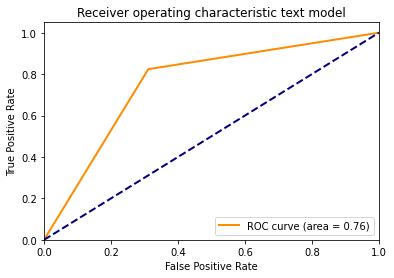

In [130]:
lw= 2
plt.plot(tpr,fpr,color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc
  )
plt.plot([0,1], [0,1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic text model")
plt.legend(loc="lower right")
plt.show()

### Analysis on Visual Data for classification

In [55]:
data_train['vision'].shape

(1284, 50, 20)

In [56]:
# preparing the data for training
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size = 64
batch_size = 64

#############################################
##### Dataset for Binary Classification #####
#############################################

train_visual_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_train['vision'], 
                    data_train['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

valid_visual_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_valid['vision'],
                    data_valid['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

test_visual_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_test['vision'],
                    data_test['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)


#################################################
##### Dataset for Multiclass Classification #####
#################################################

def convert_one_hot(x, y):
  y = tf.squeeze(y)
  return (x, tf.one_hot(tf.cast(tf.floor(y+3), tf.int64), 7))

train_visual_multi_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_train['vision'], 
                    data_train['labels']
                )
            ).map(convert_one_hot).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

valid_visual_multi_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_valid['vision'],
                    data_valid['labels']
                )
            ).map(convert_one_hot).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

test_visual_multi_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_test['vision'],
                    data_test['labels']
                )
            ).map(convert_one_hot).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

In [57]:
#################################################
##### Classification Model on visual Data   #####
#################################################

v_seq_len = 50
v_latent_dim = 20

v_input_shape = (v_seq_len, v_latent_dim)
v_mask_value = np.zeros(shape=(v_latent_dim,), dtype=np.float32)

v_input = Input(shape=v_input_shape, name='v_input_layer')
v_mask_lyr = Masking(mask_value=v_mask_value, name='v_mask_layer')
v_lstm_lyr = LSTM(256, return_sequences=False, dropout=0.4, name='v_lstm_layer_1')
v_dense_lyr = Dense(2, activation='softmax', name='v_dense_layer')


x = v_mask_lyr(v_input)
x = v_lstm_lyr(x)
x = v_dense_lyr(x)

v_model = Model(inputs=v_input, outputs=x, name='visual_classification_model')
v_model.summary()

Model: "visual_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v_input_layer (InputLayer)  [(None, 50, 20)]          0         
                                                                 
 v_mask_layer (Masking)      (None, 50, 20)            0         
                                                                 
 v_lstm_layer_1 (LSTM)       (None, 256)               283648    
                                                                 
 v_dense_layer (Dense)       (None, 2)                 514       
                                                                 
Total params: 284,162
Trainable params: 284,162
Non-trainable params: 0
_________________________________________________________________


In [58]:
v_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [59]:
v_history = v_model.fit(train_visual_binary_ds, validation_data=valid_visual_binary_ds, 
            epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/50
21/21 [==============================] - 8s 189ms/step - loss: 0.6852 - accuracy: 0.5592 - val_loss: 0.6613 - val_accuracy: 0.5895
Epoch 2/50
21/21 [==============================] - 3s 130ms/step - loss: 0.6630 - accuracy: 0.5841 - val_loss: 0.6575 - val_accuracy: 0.5895
Epoch 3/50
21/21 [==============================] - 3s 132ms/step - loss: 0.6621 - accuracy: 0.6114 - val_loss: 0.6563 - val_accuracy: 0.5983
Epoch 4/50
21/21 [==============================] - 3s 128ms/step - loss: 0.6468 - accuracy: 0.6293 - val_loss: 0.6634 - val_accuracy: 0.5983
Epoch 5/50
21/21 [==============================] - 3s 128ms/step - loss: 0.6544 - accuracy: 0.6090 - val_loss: 0.6557 - val_accuracy: 0.5983
Epoch 6/50
21/21 [==============================] - 3s 128ms/step - loss: 0.6495 - accuracy: 0.6137 - val_loss: 0.6524 - val_accuracy: 0.5895
Epoch 7/50
21/21 [==============================] - 3s 133ms/step - loss: 0.6502 - accuracy: 0.6036 - val_loss: 0.6514 - val_accuracy: 0.5852
Epoch 

In [60]:
v_model.evaluate(test_visual_binary_ds)

11/11 [==============================] - 0s 14ms/step - loss: 0.7315 - accuracy: 0.4927


[0.7314684987068176, 0.4927113652229309]

In [61]:
##############################################################
##### Classification Model on visual Data with Attention #####
##############################################################

v_seq_len = 50
v_latent_dim = 20

v_input_shape = (v_seq_len, v_latent_dim)
v_mask_value = np.zeros(shape=(v_latent_dim,), dtype=np.float32)

v_input = Input(shape=v_input_shape, name='v_input_layer')
v_mask_lyr = Masking(mask_value=v_mask_value, name='v_mask_layer')
v_lstm_lyr = LSTM(256, return_sequences=True, dropout=0.4, name='v_lstm_layer_1')
v_att_lyr = AttentionLayer()
v_dense_lyr_1 = Dense(32, activation='relu',  name='v_dense_layer_1')
v_dense_lyr_2 = Dense(2, activation='softmax', name='v_dense_layer_2')

x = v_mask_lyr(v_input)
x = v_lstm_lyr(x)
att_we, att_op = v_att_lyr(x)
op_1 = v_dense_lyr_1(att_op)
op_2 = v_dense_lyr_2(op_1)

v_model1 = Model(inputs=v_input, outputs=op_2, name='visual_classification_model_with_attention')
v_model1.summary()

Model: "visual_classification_model_with_attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 v_input_layer (InputLayer)  [(None, 50, 20)]          0         
                                                                 
 v_mask_layer (Masking)      (None, 50, 20)            0         
                                                                 
 v_lstm_layer_1 (LSTM)       (None, 50, 256)           283648    
                                                                 
 attention_layer_1 (Attentio  ((None, 50, 1),          306       
 nLayer)                      (None, 256))                       
                                                                 
 v_dense_layer_1 (Dense)     (None, 32)                8224      
                                                                 
 v_dense_layer_2 (Dense)     (None, 2)                 66        
                        

In [62]:
v_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
v_history1 = v_model1.fit(train_visual_binary_ds, validation_data=valid_visual_binary_ds, 
            epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/50
21/21 [==============================] - 8s 208ms/step - loss: 0.6924 - accuracy: 0.5779 - val_loss: 0.6793 - val_accuracy: 0.5983
Epoch 2/50
21/21 [==============================] - 3s 130ms/step - loss: 0.6802 - accuracy: 0.5935 - val_loss: 0.6709 - val_accuracy: 0.6157
Epoch 3/50
21/21 [==============================] - 3s 136ms/step - loss: 0.6687 - accuracy: 0.5958 - val_loss: 0.6731 - val_accuracy: 0.6026
Epoch 4/50
21/21 [==============================] - 3s 133ms/step - loss: 0.6584 - accuracy: 0.6184 - val_loss: 0.6625 - val_accuracy: 0.5808
Epoch 5/50
21/21 [==============================] - 3s 133ms/step - loss: 0.6652 - accuracy: 0.6114 - val_loss: 0.6612 - val_accuracy: 0.5895
Epoch 6/50
21/21 [==============================] - 3s 140ms/step - loss: 0.6475 - accuracy: 0.6223 - val_loss: 0.6626 - val_accuracy: 0.5808
Epoch 7/50
21/21 [==============================] - 3s 137ms/step - loss: 0.6577 - accuracy: 0.6215 - val_loss: 0.6705 - val_accuracy: 0.5895
Epoch 

In [63]:
v_model1.evaluate(test_visual_binary_ds)

11/11 [==============================] - 0s 14ms/step - loss: 0.6971 - accuracy: 0.5190


[0.6970657110214233, 0.5189504623413086]

In [64]:
valid_data_df['v_model1']= v_model1.predict(data_valid['vision'])[:,1] >= 0.5
valid_data_df

,f_name,s_time,e_time,true_labels,t_model,v_model1
0,b'WKA5OygbEKI_20',b'131.7929705',b'133.6886621',True,True,True
1,b'WKA5OygbEKI_21',b'133.6886621',b'138.976644',True,False,True
2,b'WKA5OygbEKI_22',b'170.544898',b'172.729932',True,True,True
3,b'WKA5OygbEKI_1',b'4.432426304',b'8.852380952',True,True,True
4,b'WKA5OygbEKI_3',b'45.95804989',b'49.69954649',True,True,True
...,...,...,...,...,...,...
224,b'c5xsKMxpXnc_4',b'133.2097506',b'135.8836735',True,True,True
225,b'c5xsKMxpXnc_7',b'149.3829932',b'152.4360544',False,False,True
226,b'c5xsKMxpXnc_6',b'146.7290249',b'149.3829932',False,False,True
227,b'c5xsKMxpXnc_9',b'156.6764172',b'159.0609977',False,False,True


In [65]:
sum(valid_data_df.true_labels == valid_data_df.v_model1) / valid_data_df.v_model1.count()

0.5982532751091703

In [132]:
#confusion matrix
v_model1_test_pred = v_model1.predict(data_test['vision'])[:,1] > 0.5
tf.math.confusion_matrix(data_test_label_actual, v_model1_test_pred, 2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[263, 190],
       [ 99, 134]], dtype=int32)>

In [174]:
# roc curve
tpr, fpr, threshold = metrics.roc_curve(data_test_label_actual, v_model1_test_pred)
roc_auc = metrics.roc_auc_score(data_test_label_actual, v_model1_test_pred)

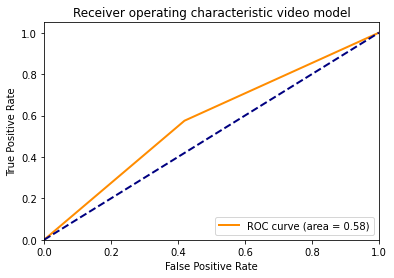

In [175]:
lw= 2
plt.plot(tpr,fpr,color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc
  )
plt.plot([0,1], [0,1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic video model")
plt.legend(loc="lower right")
plt.show()

### Analysis of Audio Data for Classification

In [66]:
data_train['audio'].shape

(1284, 50, 5)

In [67]:
# preparing the data for training
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size = 64
batch_size = 64

#############################################
##### Dataset for Binary Classification #####
#############################################

train_audio_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_train['audio'], 
                    data_train['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

valid_audio_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_valid['audio'],
                    data_valid['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

test_audio_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_test['audio'],
                    data_test['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)


#################################################
##### Dataset for Multiclass Classification #####
#################################################

def convert_one_hot(x, y):
  y = tf.squeeze(y)
  return (x, tf.one_hot(tf.cast(tf.floor(y+3), tf.int64), 7))

train_audio_multi_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_train['audio'], 
                    data_train['labels']
                )
            ).map(convert_one_hot).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

valid_audio_multi_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_valid['audio'],
                    data_valid['labels']
                )
            ).map(convert_one_hot).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

test_audio_multi_ds = tf.data.Dataset.from_tensor_slices(
                (
                    data_test['audio'],
                    data_test['labels']
                )
            ).map(convert_one_hot).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

In [68]:
#################################################
##### Classification Model on Audio Data   #####
#################################################

a_seq_len = 50
a_latent_dim = 5

a_input_shape = (a_seq_len, a_latent_dim)
a_mask_value = np.zeros(shape=(a_latent_dim,), dtype=np.float32)

a_input = Input(shape=a_input_shape, name='a_input_layer')
a_mask_lyr = Masking(mask_value=a_mask_value, name='a_mask_layer')
a_lstm_lyr = LSTM(256, return_sequences=False, dropout=0.4, name='a_lstm_layer_1')
a_dense_lyr = Dense(2, activation='softmax', name='a_dense_layer')


x = a_mask_lyr(a_input)
x = a_lstm_lyr(x)
x = a_dense_lyr(x)

a_model = Model(inputs=a_input, outputs=x, name='audio_classification_model')
a_model.summary()

Model: "audio_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 a_input_layer (InputLayer)  [(None, 50, 5)]           0         
                                                                 
 a_mask_layer (Masking)      (None, 50, 5)             0         
                                                                 
 a_lstm_layer_1 (LSTM)       (None, 256)               268288    
                                                                 
 a_dense_layer (Dense)       (None, 2)                 514       
                                                                 
Total params: 268,802
Trainable params: 268,802
Non-trainable params: 0
_________________________________________________________________


In [69]:
a_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
a_history = a_model.fit(train_audio_binary_ds, validation_data=valid_audio_binary_ds, 
            epochs=500, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/500
21/21 [==============================] - 7s 189ms/step - loss: 0.6881 - accuracy: 0.5530 - val_loss: 0.6808 - val_accuracy: 0.6070
Epoch 2/500
21/21 [==============================] - 3s 129ms/step - loss: 0.6860 - accuracy: 0.5646 - val_loss: 0.6713 - val_accuracy: 0.6026
Epoch 3/500
21/21 [==============================] - 3s 126ms/step - loss: 0.6767 - accuracy: 0.5864 - val_loss: 0.6782 - val_accuracy: 0.5852
Epoch 4/500
21/21 [==============================] - 3s 132ms/step - loss: 0.6784 - accuracy: 0.5872 - val_loss: 0.6682 - val_accuracy: 0.5939
Epoch 5/500
21/21 [==============================] - 3s 136ms/step - loss: 0.6746 - accuracy: 0.6020 - val_loss: 0.6764 - val_accuracy: 0.6026
Epoch 6/500
21/21 [==============================] - 3s 133ms/step - loss: 0.6765 - accuracy: 0.5888 - val_loss: 0.6676 - val_accuracy: 0.6070
Epoch 7/500
21/21 [==============================] - 3s 128ms/step - loss: 0.6701 - accuracy: 0.6044 - val_loss: 0.6687 - val_accuracy: 0.5983

In [70]:
a_model.evaluate(test_audio_binary_ds)

11/11 [==============================] - 0s 14ms/step - loss: 0.6981 - accuracy: 0.5423


[0.6980618238449097, 0.5422740578651428]

In [71]:
##############################################################
##### Classification Model on Audio Data with Attention #####
##############################################################

a_seq_len = 50
a_latent_dim = 5

a_input_shape = (a_seq_len, a_latent_dim)
a_mask_value = np.zeros(shape=(a_latent_dim,), dtype=np.float32)

a_input = Input(shape=a_input_shape, name='a_input_layer')
a_mask_lyr = Masking(mask_value=a_mask_value, name='a_mask_layer')
a_lstm_lyr = LSTM(256, return_sequences=True, dropout=0.4, name='a_lstm_layer_1')
a_att_lyr = AttentionLayer()
a_dense_lyr_1 = Dense(32, activation='relu',  name='a_dense_layer_1')
a_dense_lyr_2 = Dense(2, activation='softmax', name='a_dense_layer_2')

x = a_mask_lyr(a_input)
x = a_lstm_lyr(x)
att_we, att_op = a_att_lyr(x)
op_1 = a_dense_lyr_1(att_op)
op_2 = a_dense_lyr_2(op_1)

a_model1 = Model(inputs=a_input, outputs=op_2, name='audio_classification_model_with_attention')
a_model1.summary()

Model: "audio_classification_model_with_attention"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 a_input_layer (InputLayer)  [(None, 50, 5)]           0         
                                                                 
 a_mask_layer (Masking)      (None, 50, 5)             0         
                                                                 
 a_lstm_layer_1 (LSTM)       (None, 50, 256)           268288    
                                                                 
 attention_layer_2 (Attentio  ((None, 50, 1),          306       
 nLayer)                      (None, 256))                       
                                                                 
 a_dense_layer_1 (Dense)     (None, 32)                8224      
                                                                 
 a_dense_layer_2 (Dense)     (None, 2)                 66        
                         

In [72]:
a_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
a_history1 = a_model1.fit(train_audio_binary_ds, validation_data=valid_audio_binary_ds, 
            epochs=50, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/50
21/21 [==============================] - 8s 190ms/step - loss: 0.6925 - accuracy: 0.5615 - val_loss: 0.6874 - val_accuracy: 0.5677
Epoch 2/50
21/21 [==============================] - 3s 131ms/step - loss: 0.6864 - accuracy: 0.5794 - val_loss: 0.6847 - val_accuracy: 0.5895
Epoch 3/50
21/21 [==============================] - 3s 131ms/step - loss: 0.6843 - accuracy: 0.5935 - val_loss: 0.6800 - val_accuracy: 0.6157
Epoch 4/50
21/21 [==============================] - 3s 134ms/step - loss: 0.6803 - accuracy: 0.5857 - val_loss: 0.6795 - val_accuracy: 0.6070
Epoch 5/50
21/21 [==============================] - 3s 135ms/step - loss: 0.6765 - accuracy: 0.5888 - val_loss: 0.6882 - val_accuracy: 0.5721
Epoch 6/50
21/21 [==============================] - 3s 138ms/step - loss: 0.6755 - accuracy: 0.5997 - val_loss: 0.6771 - val_accuracy: 0.5939
Epoch 7/50
21/21 [==============================] - 3s 129ms/step - loss: 0.6715 - accuracy: 0.5958 - val_loss: 0.6779 - val_accuracy: 0.5939
Epoch 

In [73]:
a_model1.evaluate(test_audio_binary_ds)

11/11 [==============================] - 0s 14ms/step - loss: 0.6912 - accuracy: 0.5627


[0.6912454962730408, 0.5626822113990784]

In [74]:
valid_data_df['a_model1']= a_model1.predict(data_valid['audio'])[:,1] >= 0.5
valid_data_df

,f_name,s_time,e_time,true_labels,t_model,v_model1,a_model1
0,b'WKA5OygbEKI_20',b'131.7929705',b'133.6886621',True,True,True,True
1,b'WKA5OygbEKI_21',b'133.6886621',b'138.976644',True,False,True,True
2,b'WKA5OygbEKI_22',b'170.544898',b'172.729932',True,True,True,True
3,b'WKA5OygbEKI_1',b'4.432426304',b'8.852380952',True,True,True,True
4,b'WKA5OygbEKI_3',b'45.95804989',b'49.69954649',True,True,True,True
...,...,...,...,...,...,...,...
224,b'c5xsKMxpXnc_4',b'133.2097506',b'135.8836735',True,True,True,False
225,b'c5xsKMxpXnc_7',b'149.3829932',b'152.4360544',False,False,True,False
226,b'c5xsKMxpXnc_6',b'146.7290249',b'149.3829932',False,False,True,True
227,b'c5xsKMxpXnc_9',b'156.6764172',b'159.0609977',False,False,True,True


In [136]:
#confusion matrix
a_model1_test_pred = a_model1.predict(data_test['audio'])[:,1] > 0.5
tf.math.confusion_matrix(data_test_label_actual, a_model1_test_pred, 2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[130, 323],
       [ 27, 206]], dtype=int32)>

In [176]:
# roc curve
tpr, fpr, threshold = metrics.roc_curve(data_test_label_actual, a_model1_test_pred)
roc_auc = metrics.roc_auc_score(data_test_label_actual, a_model1_test_pred)

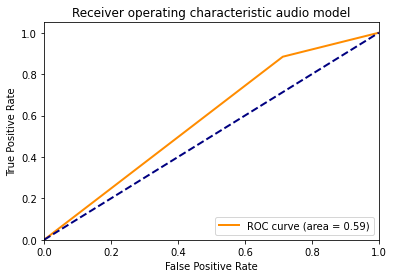

In [178]:
lw= 2
plt.plot(tpr,fpr,color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc
  )
plt.plot([0,1], [0,1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic audio model")
plt.legend(loc="lower right")
plt.show()

### T + V

In [75]:
# preparing the data for training
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size = 64
batch_size = 64

###################################################################
##### Dataset for Binary Classification Text and Visual Model #####
###################################################################

train_tv_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    (data_train['text'],
                    data_train['vision']), 
                    data_train['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

valid_tv_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    (data_valid['text'],
                    data_valid['vision']),
                    data_valid['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

test_tv_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    (data_test['text'],
                    data_test['vision']),
                    data_test['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

In [76]:
for data in train_tv_binary_ds.take(1):
  print(data)

((<tf.Tensor: shape=(64, 50, 300), dtype=float32, numpy=
array([[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [-0.13889  ,  0.10991  , -0.20471  , ..., -0.083825 ,
          0.49241  , -0.045157 ],
        [-0.20639  , -0.11403  , -0.11346  , ..., -0.2082   ,
          0.307    , -0.25052  ],
        [-0.8414   ,  0.59629  ,  0.2473   , ..., -0.29299  ,
          0.035984 , -0.4871   ]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 0.27204  , -0.06203  , -0.1884   , ...,  

In [77]:
##############################################
#### Merging textual and visual analysis #####
##############################################

t_lstm_lyr.trainable = False
t_att_lyr.trainable  = False
t_dense_lyr_1.trainable = False

v_lstm_lyr.trainable = False
v_att_lyr.trainable  = False
v_dense_lyr_1.trainable = False


t_x = t_mask_lyr(t_input)
t_x = t_lstm_lyr(t_x)
t_att_we, t_att_op = t_att_lyr(t_x)
t_op = t_dense_lyr_1(t_att_op)

v_x = v_mask_lyr(v_input)
v_x = v_lstm_lyr(v_x)
v_att_we, v_att_op = v_att_lyr(v_x)
v_op = v_dense_lyr_1(v_att_op)

# x = tf.keras.layers.concatenate((t_att_op, v_att_op))
# x = tf.keras.layers.concatenate((t_op, v_op))
x  = tf.keras.layers.Lambda(lambda x: tf.math.multiply(x[0],x[1]))((t_op, v_op))

tv_dense_1 = Dense(16, activation='softmax', name='text_visual_dense_layer_1')
tv_dense = Dense(2, activation='softmax', name='text_visual_dense_layer')

x = tv_dense_1(x)
op = tv_dense(x)

tv_model = Model(inputs=[t_input, v_input], outputs=op, name='Text_Visual_Model')
tv_model.summary()

Model: "Text_Visual_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input_layer (InputLayer)  [(None, 50, 300)]    0           []                               
                                                                                                  
 v_input_layer (InputLayer)     [(None, 50, 20)]     0           []                               
                                                                                                  
 text_masking_layer (Masking)   (None, 50, 300)      0           ['text_input_layer[0][0]']       
                                                                                                  
 v_mask_layer (Masking)         (None, 50, 20)       0           ['v_input_layer[0][0]']          
                                                                                  

In [78]:
tv_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
tv_history1 = tv_model.fit(train_tv_binary_ds, validation_data=valid_tv_binary_ds, 
            epochs=500, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/500
21/21 [==============================] - 10s 155ms/step - loss: 0.6917 - accuracy: 0.5740 - val_loss: 0.6863 - val_accuracy: 0.5983
Epoch 2/500
21/21 [==============================] - 1s 40ms/step - loss: 0.6881 - accuracy: 0.5701 - val_loss: 0.6831 - val_accuracy: 0.5983
Epoch 3/500
21/21 [==============================] - 1s 42ms/step - loss: 0.6860 - accuracy: 0.5701 - val_loss: 0.6806 - val_accuracy: 0.5983
Epoch 4/500
21/21 [==============================] - 1s 42ms/step - loss: 0.6844 - accuracy: 0.5701 - val_loss: 0.6785 - val_accuracy: 0.5983
Epoch 5/500
21/21 [==============================] - 1s 42ms/step - loss: 0.6830 - accuracy: 0.5701 - val_loss: 0.6764 - val_accuracy: 0.5983
Epoch 6/500
21/21 [==============================] - 1s 42ms/step - loss: 0.6818 - accuracy: 0.5701 - val_loss: 0.6757 - val_accuracy: 0.5983
Epoch 7/500
21/21 [==============================] - 1s 44ms/step - loss: 0.6812 - accuracy: 0.5701 - val_loss: 0.6750 - val_accuracy: 0.5983
Epoc

In [79]:
tv_model.evaluate(test_tv_binary_ds)

11/11 [==============================] - 0s 33ms/step - loss: 0.5605 - accuracy: 0.7741


[0.560467004776001, 0.7740525007247925]

In [80]:
########## Trying convulution Netwwork ##########

##############################################
#### Merging textual and visual analysis #####
##############################################

t_lstm_lyr.trainable = True
t_att_lyr.trainable  = True
t_dense_lyr_1.trainable = True

v_lstm_lyr.trainable = True
v_att_lyr.trainable  = True
v_dense_lyr_1.trainable = True


t_x = t_mask_lyr(t_input)
t_x = t_lstm_lyr(t_x)
t_att_we, t_att_op = t_att_lyr(t_x)
t_op = t_dense_lyr_1(t_att_op)

v_x = v_mask_lyr(v_input)
v_x = v_lstm_lyr(v_x)
v_att_we, v_att_op = v_att_lyr(v_x)
v_op = v_dense_lyr_1(v_att_op)

# x = tf.keras.layers.concatenate((t_att_op, v_att_op))
# x = tf.keras.layers.concatenate((t_op, v_op))


t_op_reshaped = tf.keras.layers.Reshape((8,4,1))(t_op)
v_op_reshaped = tf.keras.layers.Reshape((8,4,1))(v_op)


op_stacked = tf.keras.layers.Concatenate()([t_op_reshaped, v_op_reshaped])

x = tf.keras.layers.Conv2D(32, (1,1))(op_stacked)
x = tf.keras.layers.Conv2D(64, (1,1))(x)
x = tf.keras.layers.Flatten()(x)

# x  = tf.keras.layers.Lambda(lambda x: tf.math.multiply(x[0],x[1]))((t_op, v_op))

tv_dense_1 = Dense(16, activation='softmax', name='text_visual_dense_layer_1')
tv_dense = Dense(2, activation='softmax', name='text_visual_dense_layer')

x = tv_dense_1(x)
op = tv_dense(x)

tv_model_conv = Model(inputs=[t_input, v_input], outputs=op, name='Text_Visual_Model')
tv_model_conv.summary()

Model: "Text_Visual_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input_layer (InputLayer)  [(None, 50, 300)]    0           []                               
                                                                                                  
 v_input_layer (InputLayer)     [(None, 50, 20)]     0           []                               
                                                                                                  
 text_masking_layer (Masking)   (None, 50, 300)      0           ['text_input_layer[0][0]']       
                                                                                                  
 v_mask_layer (Masking)         (None, 50, 20)       0           ['v_input_layer[0][0]']          
                                                                                  

In [81]:
tv_model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
tv_history_conv = tv_model_conv.fit(train_tv_binary_ds, validation_data=valid_tv_binary_ds, 
            epochs=500, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/500
21/21 [==============================] - 23s 356ms/step - loss: 0.6102 - accuracy: 0.7165 - val_loss: 0.6183 - val_accuracy: 0.6725
Epoch 2/500
21/21 [==============================] - 5s 235ms/step - loss: 0.5221 - accuracy: 0.8123 - val_loss: 0.5814 - val_accuracy: 0.7205
Epoch 3/500
21/21 [==============================] - 5s 241ms/step - loss: 0.4894 - accuracy: 0.8349 - val_loss: 0.5603 - val_accuracy: 0.7424
Epoch 4/500
21/21 [==============================] - 5s 240ms/step - loss: 0.4884 - accuracy: 0.8271 - val_loss: 0.5367 - val_accuracy: 0.7642
Epoch 5/500
21/21 [==============================] - 5s 237ms/step - loss: 0.4507 - accuracy: 0.8645 - val_loss: 0.5228 - val_accuracy: 0.7860
Epoch 6/500
21/21 [==============================] - 5s 235ms/step - loss: 0.4584 - accuracy: 0.8505 - val_loss: 0.5205 - val_accuracy: 0.7860
Epoch 7/500
21/21 [==============================] - 5s 239ms/step - loss: 0.4258 - accuracy: 0.8801 - val_loss: 0.5094 - val_accuracy: 0.781

In [82]:
tv_model_conv.evaluate(test_tv_binary_ds)

11/11 [==============================] - 0s 36ms/step - loss: 0.5514 - accuracy: 0.7682


[0.5513774752616882, 0.7682215571403503]

### T + A

In [83]:
# preparing the data for training
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size = 64
batch_size = 64

###################################################################
##### Dataset for Binary Classification Text and Visual Model #####
###################################################################

train_ta_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    (data_train['text'],
                    data_train['audio']), 
                    data_train['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

valid_ta_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    (data_valid['text'],
                    data_valid['audio']),
                    data_valid['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

test_ta_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    (data_test['text'],
                    data_test['audio']),
                    data_test['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

In [84]:
for data in train_ta_binary_ds.take(1):
  print(data)

((<tf.Tensor: shape=(64, 50, 300), dtype=float32, numpy=
array([[[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [-0.30494  ,  0.01233  ,  0.038375 , ...,  0.011121 ,
          0.14095  , -0.021138 ],
        [-0.28679  ,  0.37497  , -0.55139  , ..., -0.17936  ,
          0.23549  ,  0.040642 ],
        [-0.42625  ,  0.4431   , -0.34517  , ..., -0.4303   ,
         -0.068851 ,  0.12875  ]],

       [[ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        [ 0.       ,  0.       ,  0.       , ...,  0.       ,
          0.       ,  0.       ],
        ...,
        [ 0.060216 ,  0.21799  , -0.04249  , ...,  

In [85]:
########## Trying convulution Netwwork ##########

##############################################
#### Merging textual and Audio analysis #####
##############################################

t_lstm_lyr.trainable = False
t_att_lyr.trainable  = False
t_dense_lyr_1.trainable = False

a_lstm_lyr.trainable = False
a_att_lyr.trainable  = False
a_dense_lyr_1.trainable = False


t_x = t_mask_lyr(t_input)
t_x = t_lstm_lyr(t_x)
t_att_we, t_att_op = t_att_lyr(t_x)
t_op = t_dense_lyr_1(t_att_op)

a_x = a_mask_lyr(a_input)
a_x = a_lstm_lyr(a_x)
a_att_we, a_att_op = a_att_lyr(a_x)
a_op = a_dense_lyr_1(a_att_op)

# x = tf.keras.layers.concatenate((t_att_op, v_att_op))
# x = tf.keras.layers.concatenate((t_op, v_op))


t_op_reshaped = tf.keras.layers.Reshape((8,4,1))(t_op)
a_op_reshaped = tf.keras.layers.Reshape((8,4,1))(a_op)


op_stacked = tf.keras.layers.Concatenate()([t_op_reshaped, a_op_reshaped])

x = tf.keras.layers.Conv2D(32, (1,1))(op_stacked)
x = tf.keras.layers.Conv2D(64, (1,1))(x)
x = tf.keras.layers.Flatten()(x)

# x  = tf.keras.layers.Lambda(lambda x: tf.math.multiply(x[0],x[1]))((t_op, v_op))

ta_dense_1 = Dense(16, activation='softmax', name='text_audio_dense_layer_1')
ta_dense = Dense(2, activation='softmax', name='text_audio_dense_layer')

x = ta_dense_1(x)
op = ta_dense(x)

ta_model_conv = Model(inputs=[t_input, a_input], outputs=op, name='Text_Audio_Model')
ta_model_conv.summary()

Model: "Text_Audio_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input_layer (InputLayer)  [(None, 50, 300)]    0           []                               
                                                                                                  
 a_input_layer (InputLayer)     [(None, 50, 5)]      0           []                               
                                                                                                  
 text_masking_layer (Masking)   (None, 50, 300)      0           ['text_input_layer[0][0]']       
                                                                                                  
 a_mask_layer (Masking)         (None, 50, 5)        0           ['a_input_layer[0][0]']          
                                                                                   

In [86]:
ta_model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
ta_history_conv = ta_model_conv.fit(train_ta_binary_ds, validation_data=valid_ta_binary_ds, 
            epochs=500, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/500
21/21 [==============================] - 9s 156ms/step - loss: 0.6046 - accuracy: 0.7344 - val_loss: 0.5736 - val_accuracy: 0.7511
Epoch 2/500
21/21 [==============================] - 1s 42ms/step - loss: 0.4475 - accuracy: 0.9206 - val_loss: 0.5273 - val_accuracy: 0.7948
Epoch 3/500
21/21 [==============================] - 1s 42ms/step - loss: 0.4057 - accuracy: 0.9245 - val_loss: 0.5155 - val_accuracy: 0.7991
Epoch 4/500
21/21 [==============================] - 1s 41ms/step - loss: 0.3895 - accuracy: 0.9252 - val_loss: 0.5083 - val_accuracy: 0.8035
Epoch 5/500
21/21 [==============================] - 1s 43ms/step - loss: 0.3790 - accuracy: 0.9283 - val_loss: 0.5049 - val_accuracy: 0.8035
Epoch 6/500
21/21 [==============================] - 1s 43ms/step - loss: 0.3714 - accuracy: 0.9291 - val_loss: 0.4995 - val_accuracy: 0.7948
Epoch 7/500
21/21 [==============================] - 1s 42ms/step - loss: 0.3624 - accuracy: 0.9276 - val_loss: 0.4959 - val_accuracy: 0.8122
Epoch

In [87]:
ta_model_conv.evaluate(test_ta_binary_ds)

11/11 [==============================] - 0s 34ms/step - loss: 0.5687 - accuracy: 0.7609


[0.5687164664268494, 0.7609329223632812]

### T + V + A

In [88]:
# preparing the data for training
AUTOTUNE = tf.data.experimental.AUTOTUNE
buffer_size = 64
batch_size = 64

###################################################################
##### Dataset for Binary Classification Text and Visual Model #####
###################################################################

train_tva_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    (data_train['text'],
                     data_train['vision'],
                     data_train['audio']
                    ), 
                    data_train['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

valid_tva_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    (data_valid['text'],
                     data_valid['vision'],
                     data_valid['audio']
                    ),
                    data_valid['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

test_tva_binary_ds = tf.data.Dataset.from_tensor_slices(
                (
                    (data_test['text'],
                     data_test['vision'],
                     data_test['audio']
                    ),
                    data_test['labels']
                )
            ).map(lambda x,y: (x,[1, 0]) if y < 0 else (x,[0,1])).shuffle(buffer_size).batch(batch_size).prefetch(AUTOTUNE)

In [89]:
########## Trying convulution Netwwork ##########

##############################################
#### Merging textual and Audio analysis #####
##############################################

t_lstm_lyr.trainable = False
t_att_lyr.trainable  = False
t_dense_lyr_1.trainable = False

v_lstm_lyr.trainable = False
v_att_lyr.trainable  = False
v_dense_lyr_1.trainable = False

a_lstm_lyr.trainable = False
a_att_lyr.trainable  = False
a_dense_lyr_1.trainable = False

t_x = t_mask_lyr(t_input)
t_x = t_lstm_lyr(t_x)
t_att_we, t_att_op = t_att_lyr(t_x)
t_op = t_dense_lyr_1(t_att_op)

v_x = v_mask_lyr(v_input)
v_x = v_lstm_lyr(v_x)
v_att_we, v_att_op = v_att_lyr(v_x)
v_op = v_dense_lyr_1(v_att_op)

a_x = a_mask_lyr(a_input)
a_x = a_lstm_lyr(a_x)
a_att_we, a_att_op = a_att_lyr(a_x)
a_op = a_dense_lyr_1(a_att_op)

# x = tf.keras.layers.concatenate((t_att_op, v_att_op))
# x = tf.keras.layers.concatenate((t_op, v_op))

t_op_reshaped = tf.keras.layers.Reshape((8,4,1))(t_op)
v_op_reshaped = tf.keras.layers.Reshape((8,4,1))(v_op)
a_op_reshaped = tf.keras.layers.Reshape((8,4,1))(a_op)

op_stacked = tf.keras.layers.Concatenate()([t_op_reshaped, v_op_reshaped, a_op_reshaped])

x = tf.keras.layers.Conv2D(32, (2,2))(op_stacked)
x = tf.keras.layers.Conv2D(64, (2,2))(x)
x = tf.keras.layers.Flatten()(x)

# x  = tf.keras.layers.Lambda(lambda x: tf.math.multiply(x[0],x[1]))((t_op, v_op))

tva_dense_1 = Dense(16, activation='softmax', name='text_vision_audio_dense_layer_1')
tva_dense = Dense(2, activation='softmax', name='text_vision_audio_dense_layer')

x = tva_dense_1(x)
op = tva_dense(x)

tva_model_conv = Model(inputs=[t_input, v_input, a_input], outputs=op, name='Text_Vision_Audio_Model')
tva_model_conv.summary()

Model: "Text_Vision_Audio_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input_layer (InputLayer)  [(None, 50, 300)]    0           []                               
                                                                                                  
 v_input_layer (InputLayer)     [(None, 50, 20)]     0           []                               
                                                                                                  
 a_input_layer (InputLayer)     [(None, 50, 5)]      0           []                               
                                                                                                  
 text_masking_layer (Masking)   (None, 50, 300)      0           ['text_input_layer[0][0]']       
                                                                            

In [90]:
tva_model_conv.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
tva_history_conv = tva_model_conv.fit(train_tva_binary_ds, validation_data=valid_tva_binary_ds, 
            epochs=500, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/500
21/21 [==============================] - 15s 230ms/step - loss: 0.6241 - accuracy: 0.7936 - val_loss: 0.5854 - val_accuracy: 0.7860
Epoch 2/500
21/21 [==============================] - 1s 56ms/step - loss: 0.4745 - accuracy: 0.9245 - val_loss: 0.5327 - val_accuracy: 0.7991
Epoch 3/500
21/21 [==============================] - 1s 58ms/step - loss: 0.4100 - accuracy: 0.9276 - val_loss: 0.5163 - val_accuracy: 0.7991
Epoch 4/500
21/21 [==============================] - 1s 56ms/step - loss: 0.3908 - accuracy: 0.9291 - val_loss: 0.5093 - val_accuracy: 0.7948
Epoch 5/500
21/21 [==============================] - 1s 57ms/step - loss: 0.3791 - accuracy: 0.9283 - val_loss: 0.5033 - val_accuracy: 0.7991
Epoch 6/500
21/21 [==============================] - 1s 57ms/step - loss: 0.3693 - accuracy: 0.9283 - val_loss: 0.4997 - val_accuracy: 0.7991
Epoch 7/500
21/21 [==============================] - 1s 57ms/step - loss: 0.3610 - accuracy: 0.9299 - val_loss: 0.4956 - val_accuracy: 0.7991
Epoc

In [91]:
tva_model_conv.evaluate(test_tva_binary_ds)

11/11 [==============================] - 1s 48ms/step - loss: 0.5545 - accuracy: 0.7638


[0.554540753364563, 0.7638484239578247]

In [142]:
tva_model_conv_test_pred

array([ True,  True, False, False, False, False,  True, False, False,
       False, False,  True,  True, False,  True, False, False, False,
        True,  True,  True,  True, False, False, False,  True, False,
       False,  True, False, False,  True, False,  True, False, False,
       False,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True, False, False,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
       False, False,  True, False, False, False, False, False,  True,
       False,  True,  True,  True, False, False, False,  True,  True,
       False,  True, False, False,  True, False,  True, False, False,
       False,  True, False,  True,  True, False,  True,  True, False,
       False, False,  True, False, False, False, False,  True, False,
        True, False, False, False, False,  True, False,  True, False,
       False,  True, False, False,  True, False, False,  True,  True,
       False, False,

In [168]:
# tva_model_conv.predict(test_tva_binary_ds)
actual = []
pred = []
for data in test_tva_binary_ds:
  pred.extend(tva_model_conv.predict(data[0])[:,1] > 0.5)
  actual.extend((data[1][:,1] == 1).numpy())

In [169]:
print(len(pred))
print(len(actual))

686
686


In [170]:
#confusion matrix
# tva_model_conv_test_pred = tva_model_conv.predict(test_tva_binary_ds)[:,1] > 0.5
tf.math.confusion_matrix(actual, pred, 2)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[295,  84],
       [ 78, 229]], dtype=int32)>

In [171]:
# roc curve
tpr, fpr, threshold = metrics.roc_curve(actual, pred)
roc_auc = metrics.roc_auc_score(actual, pred)

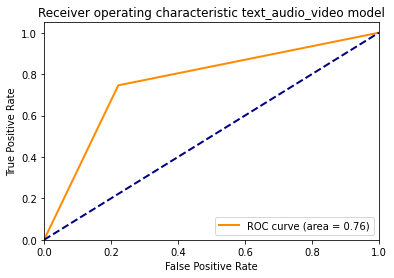

In [173]:
lw= 2
plt.plot(tpr,fpr,color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc
  )
plt.plot([0,1], [0,1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic text_audio_video model")
plt.legend(loc="lower right")
plt.show()

In [92]:
tva_input_raw = (data_valid['text'], data_valid['vision'], data_valid['audio'])
valid_data_df['tva_model_conv'] = tva_model_conv.predict(tva_input_raw)[:,1] >= 0.5
valid_data_df

,f_name,s_time,e_time,true_labels,t_model,v_model1,a_model1,tva_model_conv
0,b'WKA5OygbEKI_20',b'131.7929705',b'133.6886621',True,True,True,True,True
1,b'WKA5OygbEKI_21',b'133.6886621',b'138.976644',True,False,True,True,False
2,b'WKA5OygbEKI_22',b'170.544898',b'172.729932',True,True,True,True,True
3,b'WKA5OygbEKI_1',b'4.432426304',b'8.852380952',True,True,True,True,True
4,b'WKA5OygbEKI_3',b'45.95804989',b'49.69954649',True,True,True,True,True
...,...,...,...,...,...,...,...,...
224,b'c5xsKMxpXnc_4',b'133.2097506',b'135.8836735',True,True,True,False,True
225,b'c5xsKMxpXnc_7',b'149.3829932',b'152.4360544',False,False,True,False,False
226,b'c5xsKMxpXnc_6',b'146.7290249',b'149.3829932',False,False,True,True,False
227,b'c5xsKMxpXnc_9',b'156.6764172',b'159.0609977',False,False,True,True,False


In [93]:
sum(valid_data_df.true_labels == valid_data_df.tva_model_conv) / valid_data_df.tva_model_conv.count()

0.8078602620087336

#### Using attention on combination of all modalities.

In [94]:
########## Trying convulution Netwwork ##########

##############################################
#### Merging textual and Audio analysis #####
##############################################

t_lstm_lyr.trainable = False
t_att_lyr.trainable  = False
t_dense_lyr_1.trainable = False

v_lstm_lyr.trainable = False
v_att_lyr.trainable  = False
v_dense_lyr_1.trainable = False

a_lstm_lyr.trainable = False
a_att_lyr.trainable  = False
a_dense_lyr_1.trainable = False

t_x = t_mask_lyr(t_input)
t_x = t_lstm_lyr(t_x)
t_att_we, t_att_op = t_att_lyr(t_x)
t_op = t_dense_lyr_1(t_att_op)

v_x = v_mask_lyr(v_input)
v_x = v_lstm_lyr(v_x)
v_att_we, v_att_op = v_att_lyr(v_x)
v_op = v_dense_lyr_1(v_att_op)

a_x = a_mask_lyr(a_input)
a_x = a_lstm_lyr(a_x)
a_att_we, a_att_op = a_att_lyr(a_x)
a_op = a_dense_lyr_1(a_att_op)

# x = tf.keras.layers.concatenate((t_att_op, v_att_op))
# x = tf.keras.layers.concatenate((t_op, v_op))

t_op_reshaped = tf.keras.layers.Reshape((1,32))(t_op)
v_op_reshaped = tf.keras.layers.Reshape((1,32))(v_op)
a_op_reshaped = tf.keras.layers.Reshape((1,32))(a_op)

op_stacked = tf.keras.layers.Concatenate(axis=1)([t_op_reshaped, v_op_reshaped, a_op_reshaped])

tva_att_lyr = AttentionLayer()
tva_att_we, tva_att_op = tva_att_lyr(op_stacked)

# x = tf.keras.layers.Conv2D(32, (2,2))(op_stacked)
# x = tf.keras.layers.Conv2D(64, (2,2))(x)
# x = tf.keras.layers.Flatten()(x)

# x  = tf.keras.layers.Lambda(lambda x: tf.math.multiply(x[0],x[1]))((t_op, v_op))

tva_dense_1 = Dense(16, activation='softmax', name='text_vision_audio_dense_layer_1')
tva_dense = Dense(2, activation='softmax', name='text_vision_audio_dense_layer')

x = tva_dense_1(tva_att_op)
op = tva_dense(x)

tva_model_att = Model(inputs=[t_input, v_input, a_input], outputs=op, name='Text_Vision_Audio_Model')
tva_model_att.summary()

Model: "Text_Vision_Audio_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input_layer (InputLayer)  [(None, 50, 300)]    0           []                               
                                                                                                  
 v_input_layer (InputLayer)     [(None, 50, 20)]     0           []                               
                                                                                                  
 a_input_layer (InputLayer)     [(None, 50, 5)]      0           []                               
                                                                                                  
 text_masking_layer (Masking)   (None, 50, 300)      0           ['text_input_layer[0][0]']       
                                                                            

In [95]:
tva_model_att.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
tva_history_att = tva_model_att.fit(train_tva_binary_ds, validation_data=valid_tva_binary_ds, 
            epochs=500, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/500
21/21 [==============================] - 15s 226ms/step - loss: 0.6816 - accuracy: 0.5701 - val_loss: 0.6722 - val_accuracy: 0.5983
Epoch 2/500
21/21 [==============================] - 1s 55ms/step - loss: 0.6746 - accuracy: 0.5701 - val_loss: 0.6682 - val_accuracy: 0.5983
Epoch 3/500
21/21 [==============================] - 1s 56ms/step - loss: 0.6665 - accuracy: 0.5717 - val_loss: 0.6630 - val_accuracy: 0.5983
Epoch 4/500
21/21 [==============================] - 1s 56ms/step - loss: 0.6565 - accuracy: 0.5748 - val_loss: 0.6569 - val_accuracy: 0.5939
Epoch 5/500
21/21 [==============================] - 1s 56ms/step - loss: 0.6449 - accuracy: 0.5950 - val_loss: 0.6495 - val_accuracy: 0.6114
Epoch 6/500
21/21 [==============================] - 1s 56ms/step - loss: 0.6317 - accuracy: 0.6075 - val_loss: 0.6419 - val_accuracy: 0.6157
Epoch 7/500
21/21 [==============================] - 1s 56ms/step - loss: 0.6173 - accuracy: 0.6472 - val_loss: 0.6342 - val_accuracy: 0.6376
Epoc

In [96]:
tva_model_att.evaluate(test_tva_binary_ds)

11/11 [==============================] - 1s 44ms/step - loss: 0.5772 - accuracy: 0.7551


[0.5771806240081787, 0.7551020383834839]

In [97]:
tva_input_raw = (data_valid['text'], data_valid['vision'], data_valid['audio'])
valid_data_df['tva_model_att'] = tva_model_att.predict(tva_input_raw)[:,1] >= 0.5
valid_data_df

,f_name,s_time,e_time,true_labels,t_model,v_model1,a_model1,tva_model_conv,tva_model_att
0,b'WKA5OygbEKI_20',b'131.7929705',b'133.6886621',True,True,True,True,True,True
1,b'WKA5OygbEKI_21',b'133.6886621',b'138.976644',True,False,True,True,False,False
2,b'WKA5OygbEKI_22',b'170.544898',b'172.729932',True,True,True,True,True,True
3,b'WKA5OygbEKI_1',b'4.432426304',b'8.852380952',True,True,True,True,True,True
4,b'WKA5OygbEKI_3',b'45.95804989',b'49.69954649',True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...
224,b'c5xsKMxpXnc_4',b'133.2097506',b'135.8836735',True,True,True,False,True,True
225,b'c5xsKMxpXnc_7',b'149.3829932',b'152.4360544',False,False,True,False,False,False
226,b'c5xsKMxpXnc_6',b'146.7290249',b'149.3829932',False,False,True,True,False,False
227,b'c5xsKMxpXnc_9',b'156.6764172',b'159.0609977',False,False,True,True,False,False


In [98]:
valid_data_df.to_excel('output_comparison.xls')

In [99]:
from google.colab import files
files.download('output_comparison.xls')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [100]:
#### finidng the Threshold value
def optimal_threshold(model, ds, threshold=[x/10 for x in range(1, 10)]):
  y_pred = []
  y_true = []
  print(model.name)
  for data in ds:
    y_pred.append(model.predict(data[0]))
    y_true.append(data[1])

  y_pred_all = np.concatenate(y_pred)
  y_true_all = np.concatenate(y_true)

  for thres in threshold:
    metric = tfa.metrics.F1Score(num_classes=2, threshold=thres)
    metric.update_state(y_true_all, y_pred_all)
    result = metric.result()
    print(f'{thres}:{result.numpy()}')


optimal_threshold(tva_model_att, test_tva_binary_ds)

Text_Vision_Audio_Model
0.1:[0.7390396 0.6183283]
0.2:[0.757327  0.6844014]
0.3:[0.76637816 0.70572567]
0.4:[0.7776333 0.7254335]
0.5:[0.7704919  0.73749995]
0.6:[0.7205882 0.7164179]
0.7:[0.64412236 0.66429836]
0.8:[0.52110094 0.60115606]
0.9:[0.        0.3961353]


In [101]:
optimal_threshold(tva_model_conv, test_tva_binary_ds)

Text_Vision_Audio_Model
0.1:[0.7117371 0.6183283]
0.2:[0.7860825 0.6183283]
0.3:[0.78636956 0.73865414]
0.4:[0.786755   0.74167985]
0.5:[0.78457445 0.73870975]
0.6:[0.780027 0.73906 ]
0.7:[0.7721692  0.73234814]
0.8:[0.         0.72147655]
0.9:[0. 0.]


In [102]:
y_true = []
y_pred = []
for data in test_tva_binary_ds:
  y_pred.append(tva_model_att.predict(data[0]))
  y_true.append(data[1])

y_true_all = np.concatenate(y_true)
y_pred_all = np.concatenate(y_pred)

In [103]:
y_pred_yes = y_pred_all[:,1] > 0.5
y_true_yes = y_true_all[:,1]
sum(y_true_yes == y_pred_yes) / len(y_true_yes)

0.7551020408163265